In [2]:
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
import numpy as np
import mplfinance as mpf

In [3]:
np.random.seed(123)

In [4]:
# a relevant .pgpass file is required to access WRDS
db = wrds.Connection(wrds_username='ncarbone')

Loading library list...
Done


In [6]:
estimates_summary = pd.read_csv('summarized_data/estimates_summary.csv', parse_dates=['earnings_date'], infer_datetime_format=True)
estimates_summary = estimates_summary.set_index(['symbol', 'earnings_date'])

In [11]:
with open('summarized_data/dataset_dtypes.json') as f:
    dtypes = json.load(f)

date_types = [col for col, dtype in dtypes.items() if dtype == 'datetime64[ns]']
dtypes = {col : dtype for col, dtype in dtypes.items() if dtype != 'datetime64[ns]'}

df = pd.read_csv('summarized_data/dataset.csv', dtype=dtypes, parse_dates=date_types, infer_datetime_format=True)
df = df.set_index(['symbol', 'earnings_date', 'date', 'time'])

df.sort_index(ascending=True, inplace=True)

In [12]:
# We'll only consider market hours
idx = pd.IndexSlice
df = df.loc[idx[:,:,:,'1900-01-01 9:30:00':'1900-01-01 15:59:00']]

In [14]:
# split dataset into train and test sets (usiing 80/20 rule)
test_frac = .2

test = df.sample(frac=test_frac)
df = df.loc[df.index.difference(test.index)]

test.to_csv('summarized_data/test_dataset.csv')
df.to_csv('summarized_data/train_dataset.csv')

In [15]:
symbols = sorted(df.index.get_level_values('symbol').unique())
symbol_dates = {symbol : df.xs(symbol, level='symbol').index.get_level_values('date') for symbol in symbols}

rand_symbol = np.random.choice(symbols)
rand_date = pd.Timestamp(np.random.choice(symbol_dates[rand_symbol]))

print(rand_symbol, rand_date.strftime('%Y-%m-%d'))

WMT 2010-08-10


## Figure 1: example of one trading day

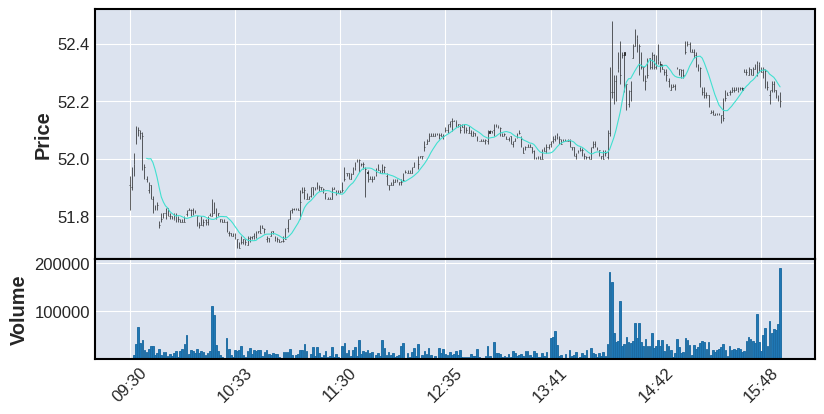

In [16]:
ohlc = df.xs((rand_symbol, rand_date), level=['symbol', 'date']).droplevel('earnings_date')
ohlc = ohlc[['open', 'high', 'low', 'close', 'volume']]

mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(ohlc, type='candlestick', volume=True, figsize=(10,5), mav=(9))

In [17]:
ticker_map = db.raw_sql(
    '''
    select 
        cusip, 
        ticker 
    from crsp.stocknames 
    where ticker in {symbols}
    '''.format(symbols=str(tuple(symbols)))
).drop_duplicates()

In [18]:
cusips = str(tuple(ticker_map['cusip']))

In [19]:
daily_data = db.raw_sql(
    '''
    select
        date,
        cusip,
        openprc as open,
        bidlo as low,
        askhi as high,
        prc as close,
        vol as volume
    from crsp_a_stock.dsf
    where cusip in {cusips}
    '''.format(cusips=cusips)
)

symbol_map = ticker_map.set_index('cusip')['ticker'].to_dict()
daily_data['symbol'] = daily_data['cusip'].map(symbol_map)
daily_data['date'] = daily_data['date'].pipe(pd.to_datetime, format='%Y-%m-%d')

In [20]:
years = range(2004, 2020)

pal = sns.color_palette('deep', 4)

for symbol in symbols:
    date_subset = df.loc[symbol].index.get_level_values('date').drop_duplicates()
    earnings_flag = daily_data.loc[daily_data['symbol'] == symbol, 'date'].isin(date_subset)
    
    daily_data.loc[(daily_data['symbol'] == symbol), 'earning_flag'] = earnings_flag 
    # update this to actually use a 2-length palette ...
    daily_data.loc[(daily_data['symbol'] == symbol), 'color'] = earnings_flag.map({True : pal[-1], False : pal[0]})

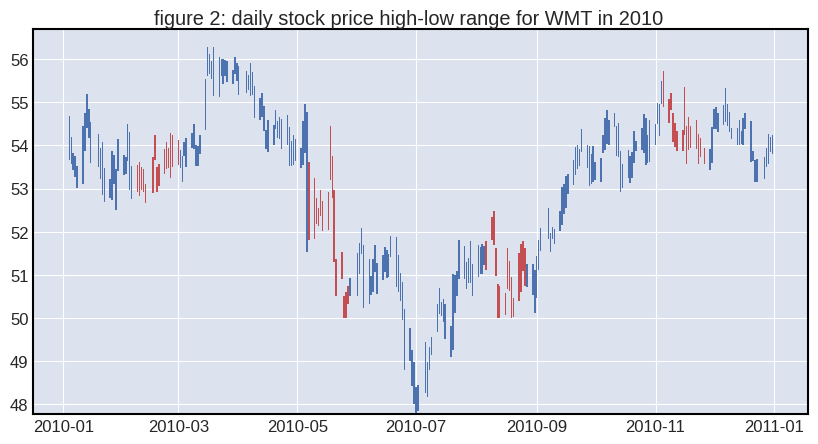

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

subset = daily_data.loc[
    (daily_data['symbol'] == rand_symbol) &
    (daily_data['date'].dt.year == rand_date.year)
]

ax.bar(x=subset['date'], height=subset['high'] - subset['low'], bottom=subset['low'], color=subset['color'], width=.75, linewidth=0)

t = fig.suptitle('figure 2: daily stock price high-low range for {} in {}'.format(rand_symbol, rand_date.year), y=.92, font={'size' : 18, 'weight' : 'bold'})

In [22]:
df['earnings_date_offset'] = df.index.get_level_values('date') - df.index.get_level_values('earnings_date')
df['earnings_date_offset'] = df['earnings_date_offset'].dt.days

relative_offset = df.groupby(['symbol', 'earnings_date']).apply(lambda x: x['earnings_date_offset'].drop_duplicates().rank()).droplevel('time').droplevel([2,3])
relative_offset = relative_offset - 8
relative_offset.name = 'relative_offset'

df = df.join(relative_offset)

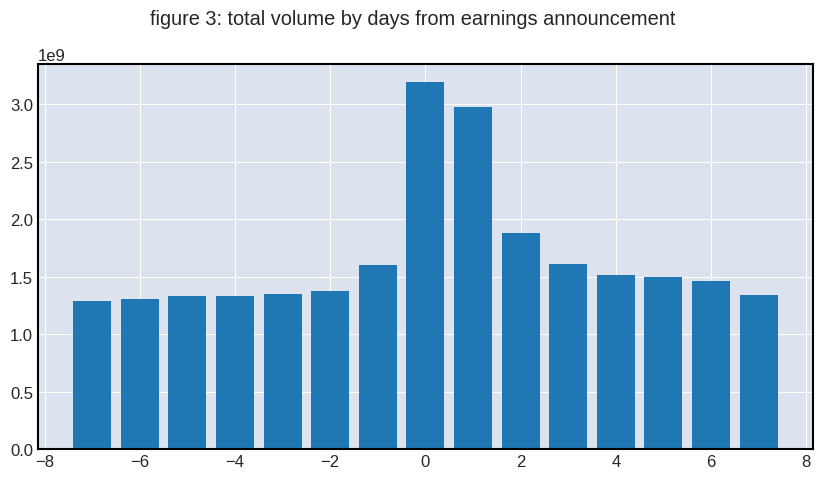

In [23]:
volumes = df.groupby('relative_offset')['volume'].sum()

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(volumes.index, volumes.values)

title = fig.suptitle('figure 3: total volume by days from earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

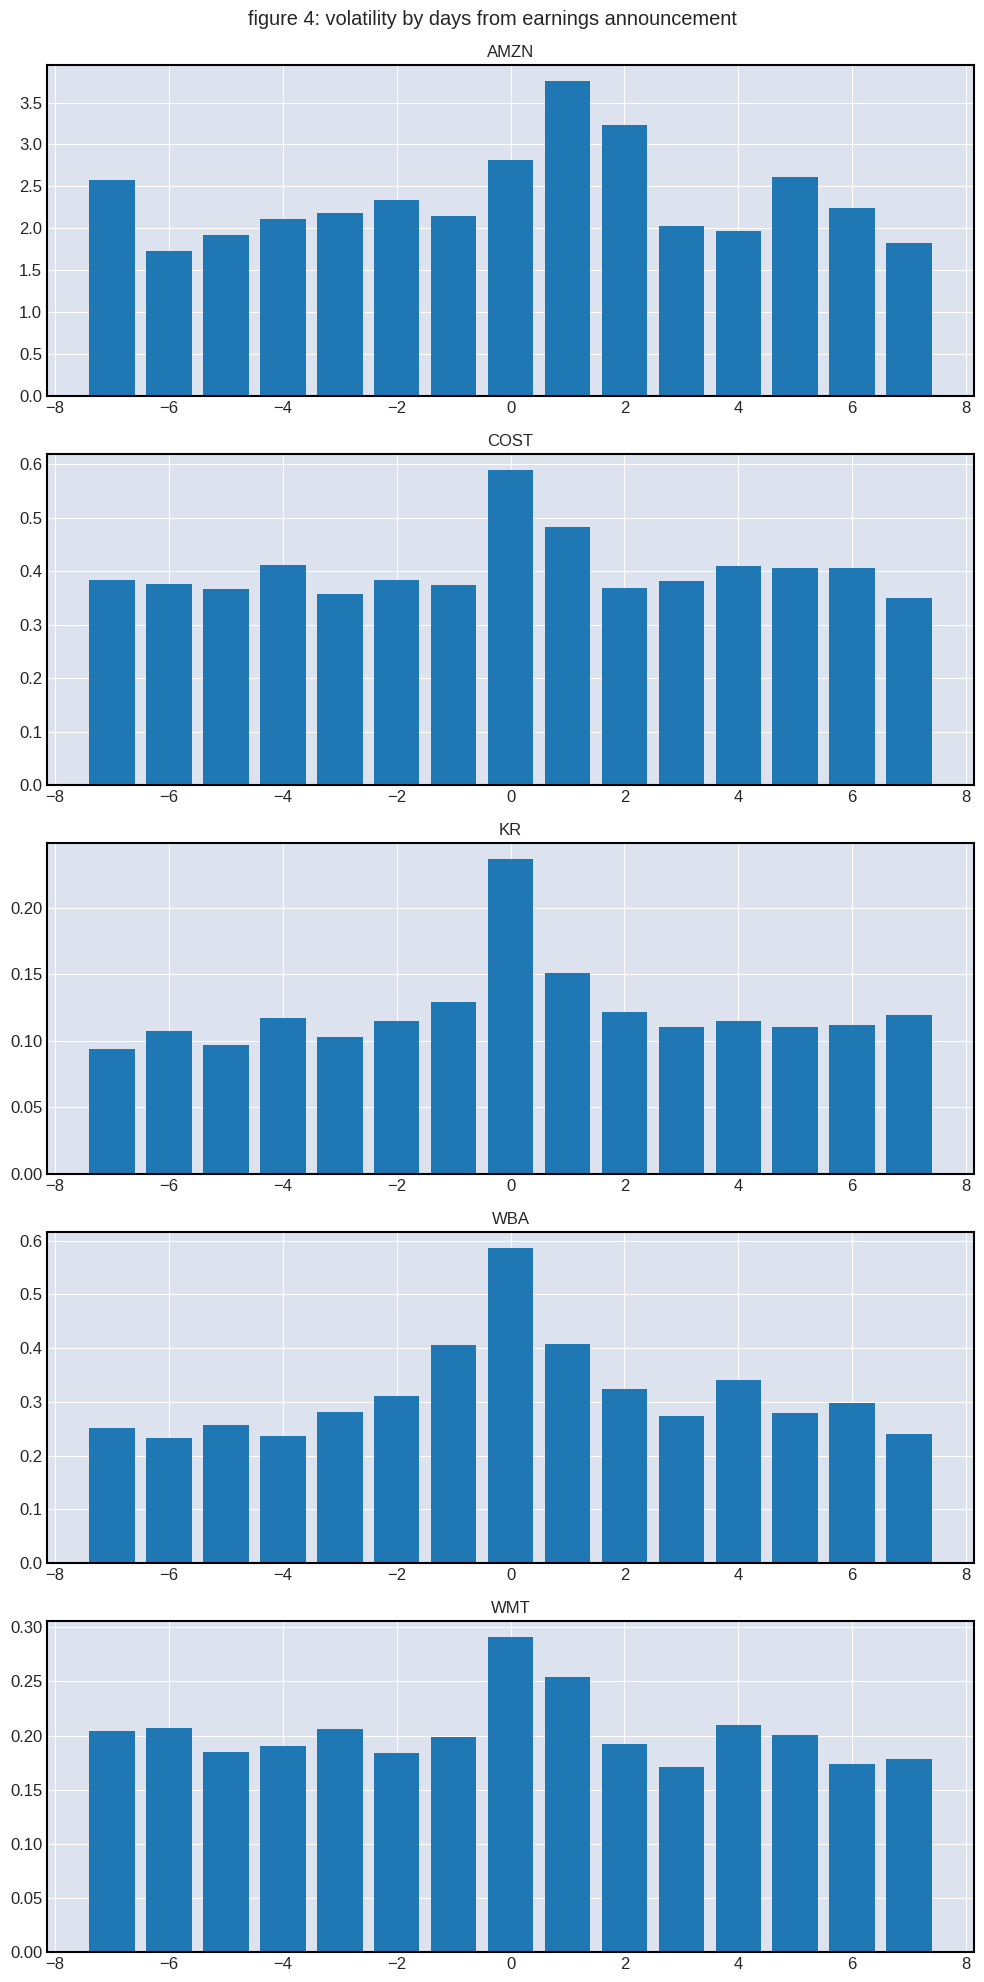

In [24]:
df['mean_price'] = df[['open', 'close', 'high', 'low']].sum(axis=1) / 4

volatility = df.groupby(['symbol', 'earnings_date', 'relative_offset'])['mean_price'].std()
volatility = volatility.groupby(['symbol', 'relative_offset']).mean()

fig, axes = plt.subplots(5, 1, figsize=(10,20))
fig.suptitle('figure 4: volatility by days from earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

for i, symbol in enumerate(symbols):
    tmp = volatility.loc[(symbol,)]
    ax = axes[i]
    ax.bar(tmp.index, tmp.values)
    ax.set_title(symbol, font={'size' : 12})

plt.tight_layout()

In [25]:
est_differences = estimates_summary['actual'] - estimates_summary['mean_est']

on_date = df.loc[df['earnings_date_offset'] == 0]
after_date = df.loc[df['earnings_date_offset'] > 0]

close_on_date = on_date.groupby(['symbol','earnings_date']).apply(lambda x: x.sort_values('time', ascending=False).iloc[0]['close'])
close_on_date.name = 'close'

open_ix = after_date.sort_values('time').groupby(['symbol', 'earnings_date'])['earnings_date_offset'].idxmin()
open_after_date = after_date.loc[open_ix, 'open'].droplevel('time')

change_after_date_7day = after_date.groupby(['symbol', 'earnings_date']).agg({'high' : 'max', 'low' : 'min'})
change_after_date_7day.columns = ['7day_high', '7day_low']

change_after_date_1day = after_date.loc[after_date['relative_offset'] == 1].groupby(['symbol', 'earnings_date']).agg({'high' : 'max', 'low' : 'min'})
change_after_date_1day.columns = ['1day_high', '1day_low']

change_6day_after_1day = after_date.loc[after_date['relative_offset'] > 1].groupby(['symbol', 'earnings_date']).agg({'high' : 'max', 'low' : 'min'})
change_6day_after_1day.columns = ['6day_after_1day_high', '6day_after_1day_low']


change_comparison = change_after_date_7day \
                                        .join(change_after_date_1day) \
                                        .join(change_6day_after_1day) \
                                        .join(close_on_date) \
                                        .join(open_after_date)

# Initital price change
change_comparison['init_price_deviation'] = change_comparison['open'] - change_comparison['close']
change_comparison['init_pct_price_deviation'] = change_comparison['init_price_deviation'] / change_comparison['close']

# Highs / lows within 7 days following announcement
large_dev_ix = change_comparison[['7day_high', '7day_low']].sub(change_comparison['close'],axis=0).abs().idxmax(axis=1)
change_comparison['7day_deviation_price'] = change_comparison.apply(lambda x: x[large_dev_ix[x.name]], axis=1)
change_comparison['7day_pct_price_deviation'] = (change_comparison['7day_deviation_price'] - change_comparison['close']) / change_comparison['close']

# Highs / lows day following announcement
large_dev_ix = change_comparison[['1day_high', '1day_low']].sub(change_comparison['close'],axis=0).abs().idxmax(axis=1)
change_comparison['1day_deviation_price'] = change_comparison.apply(lambda x: x[large_dev_ix[x.name]], axis=1)
change_comparison['1day_pct_price_deviation'] = (change_comparison['1day_deviation_price'] - change_comparison['close']) / change_comparison['close']

# Highs / lows 6 days after day following announcment
large_dev_ix = change_comparison[['6day_after_1day_high', '6day_after_1day_low']].sub(change_comparison['close'],axis=0).abs().idxmax(axis=1)
change_comparison['6day_deviation_price'] = change_comparison.apply(lambda x: x[large_dev_ix[x.name]], axis=1)
change_comparison['6day_pct_price_deviation'] = (change_comparison['6day_deviation_price'] - change_comparison['close']) / change_comparison['close']

# Combine with estimates
estimates_summary['pct_mean_est_deviation'] = (estimates_summary['actual'] - estimates_summary['mean_est']) / estimates_summary['mean_est']
change_comparison = change_comparison.join(estimates_summary)

In [26]:
def direction_table(data, symbol):
    tmp = data.loc[(symbol)]
    
    table = pd.DataFrame({
    'est_direction' : np.sign(tmp['pct_mean_est_deviation']),
    '1day_price_direction' : np.sign(tmp['1day_pct_price_deviation'])
    }).value_counts().unstack(level=-1).fillna(0).round(0).astype(int)
    
    return table

direction_summary = pd.concat([direction_table(change_comparison, symbol) for symbol in symbols], axis=1, keys=symbols)

direction_summary.loc['Total'] = direction_summary.sum(axis=0)
direction_summary['Total'] = direction_summary.sum(axis=1)

## Table 1: summary of initial price changes vs. differences in analyst estimates

In [27]:
direction_summary

AMZN     COST       KR      WBA      WMT     Total
1day_price_direction -1.0 1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0      
est_direction                                                          
-1.0                   24  20   15  12   16   8    5   3   22   6   131
1.0                    10  12   20  18   17  24    6   7   21  16   151
Total                  34  32   35  30   33  32   11  10   43  22   282

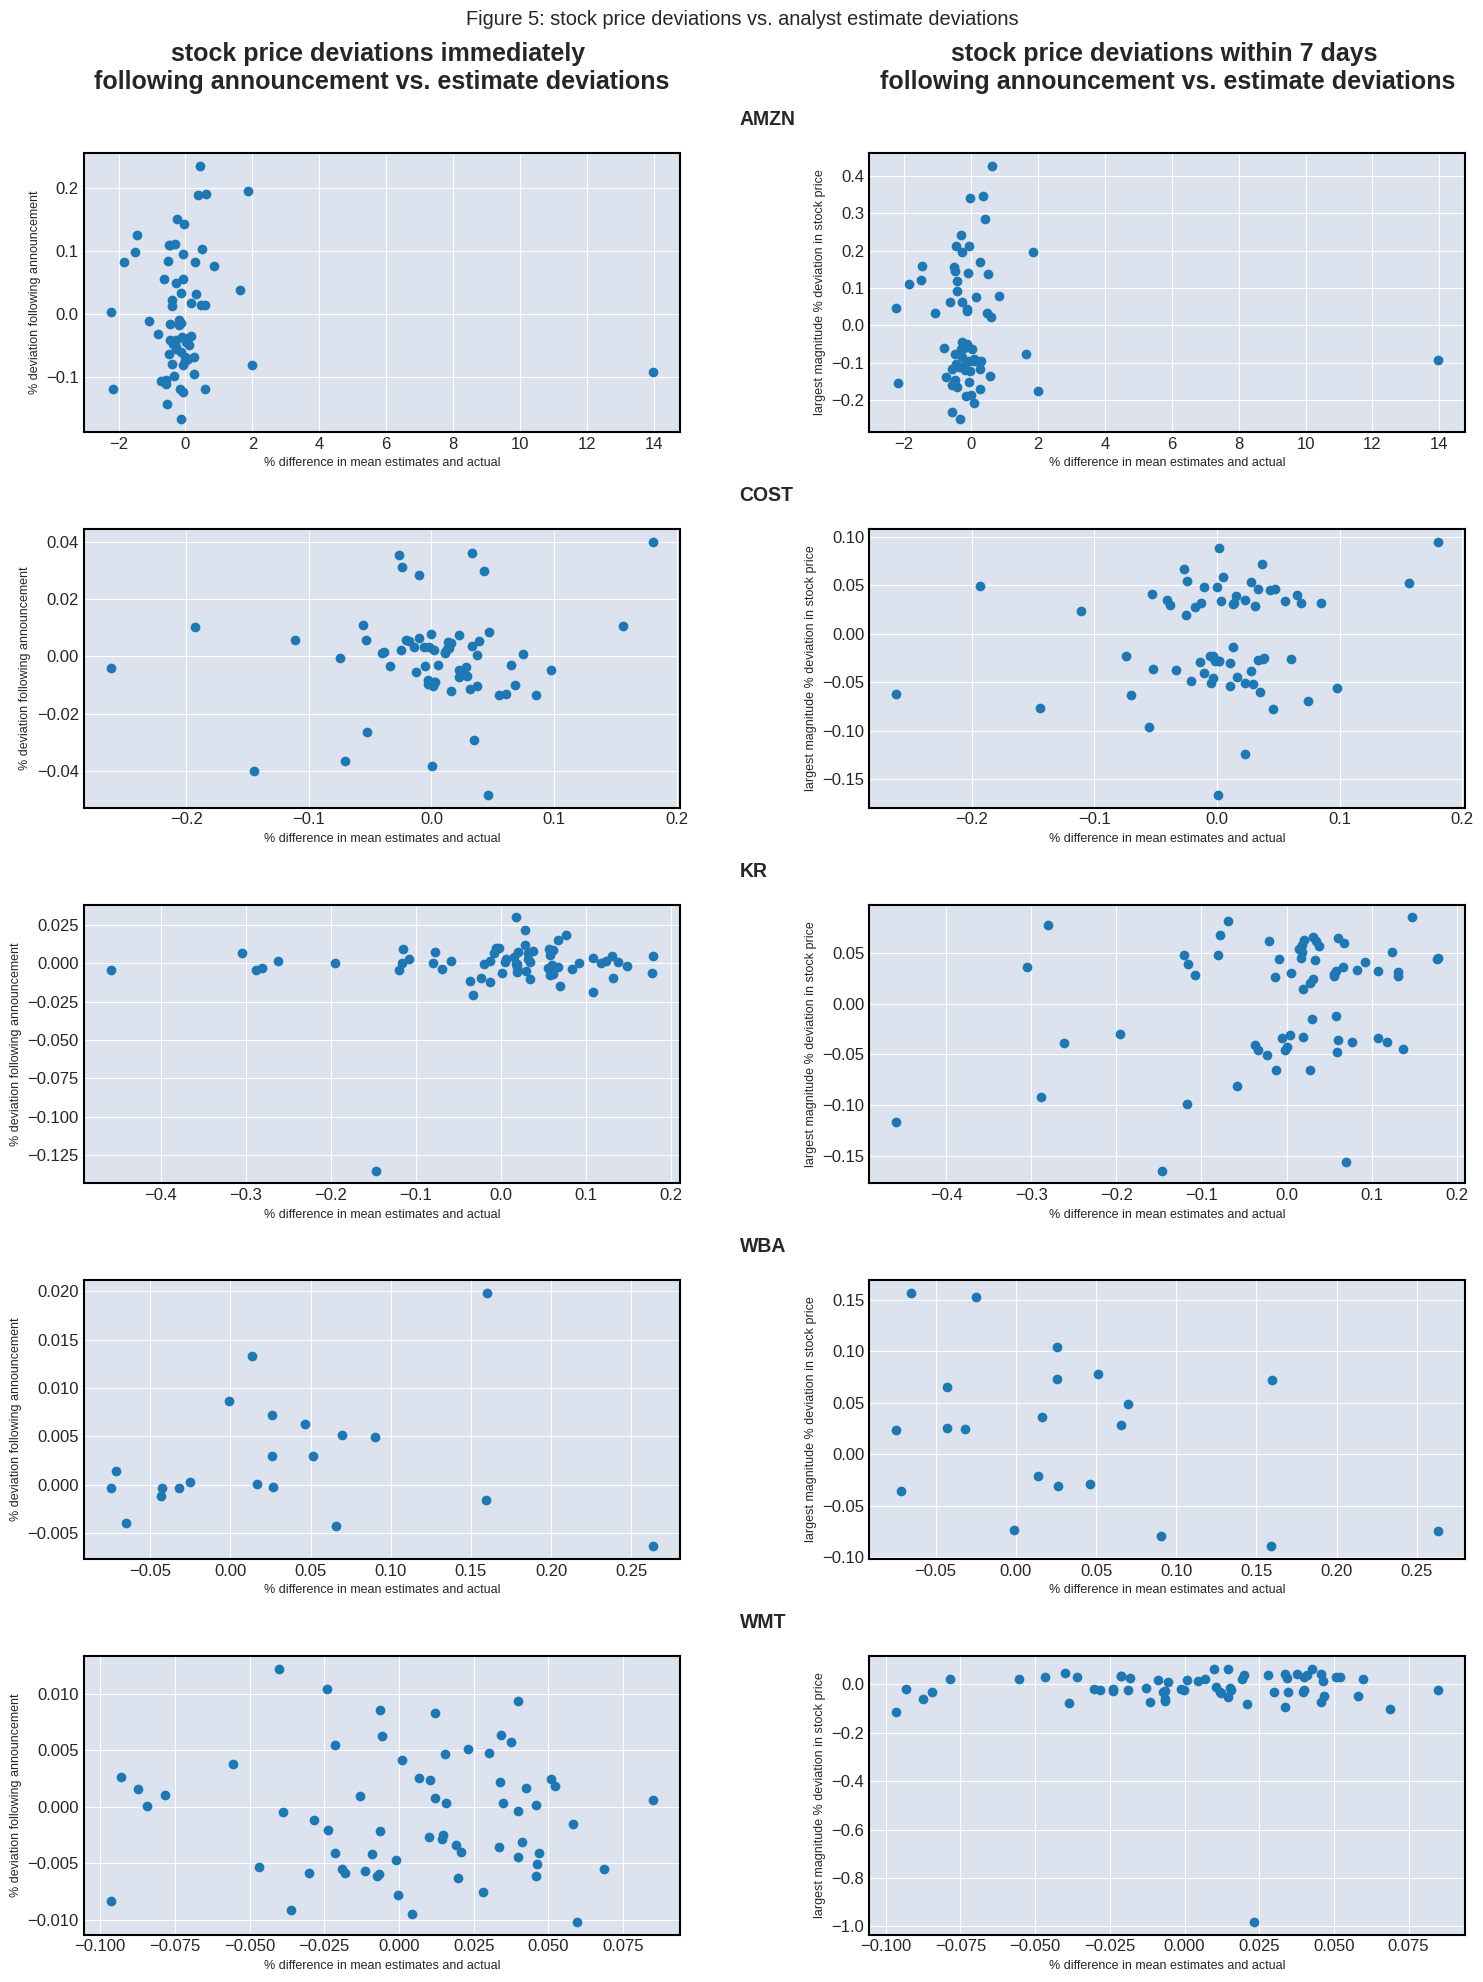

In [28]:
fig, axes = plt.subplots(5,2,figsize=(15,20))


for i, symbol in enumerate(symbols):
    ax = axes[i,0]
    tmp = change_comparison.loc[(symbol)]
    ax.scatter(tmp['pct_mean_est_deviation'], tmp['init_pct_price_deviation'])
    ax.set_xlabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
    ax.set_ylabel('% deviation following announcement', font={'size' : 9, 'weight' : 'normal'})
    if i == 0:
        ax.set_title('stock price deviations immediately \nfollowing announcement vs. estimate deviations', y=1.2, font={'size' : 18, 'weight' : 'bold'})
    
    ax.annotate('{}'.format(symbol), xy=(1.1,1.1), xycoords=ax.transAxes, font={'size' : 14, 'weight' : 'bold'})
    
    ax = axes[i,1]
    tmp = change_comparison.loc[(symbol)]
    ax.scatter(tmp['pct_mean_est_deviation'], tmp['7day_pct_price_deviation'])
    ax.set_xlabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
    ax.set_ylabel('largest magnitude % deviation in stock price', font={'size' : 9, 'weight' : 'normal'})
    
    if i == 0:
        ax.set_title('stock price deviations within 7 days \nfollowing announcement vs. estimate deviations', y=1.2, font={'size' : 18, 'weight' : 'bold'})
        
fig.suptitle('Figure 5: stock price deviations vs. analyst estimate deviations', y=.99, font={'size' : 18, 'weight' : 'bold'})
        
fig.tight_layout()

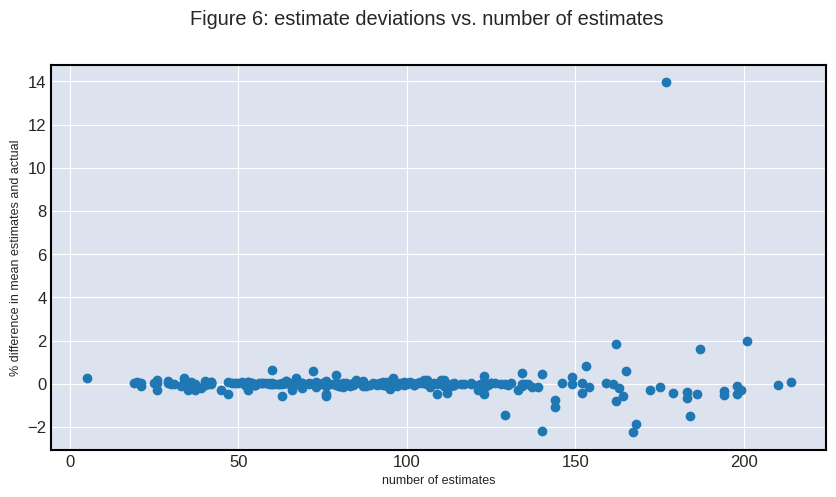

In [29]:
# this differs from the paper

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(estimates_summary['n_est'], estimates_summary['pct_mean_est_deviation'])

ax.set_xlabel('number of estimates', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
title = fig.suptitle('Figure 6: estimate deviations vs. number of estimates', y=.99, font={'size' : 18, 'weight' : 'bold'})

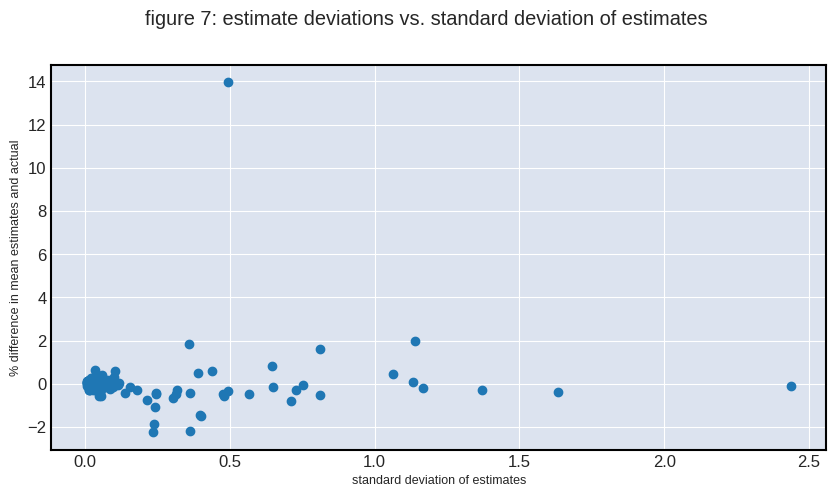

In [30]:
# this differs from the paper

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(estimates_summary['std_est'], estimates_summary['pct_mean_est_deviation'])

ax.set_xlabel('standard deviation of estimates', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('% difference in mean estimates and actual', font={'size' : 9, 'weight' : 'normal'})
title = fig.suptitle('figure 7: estimate deviations vs. standard deviation of estimates', y=.99, font={'size' : 18, 'weight' : 'bold'})

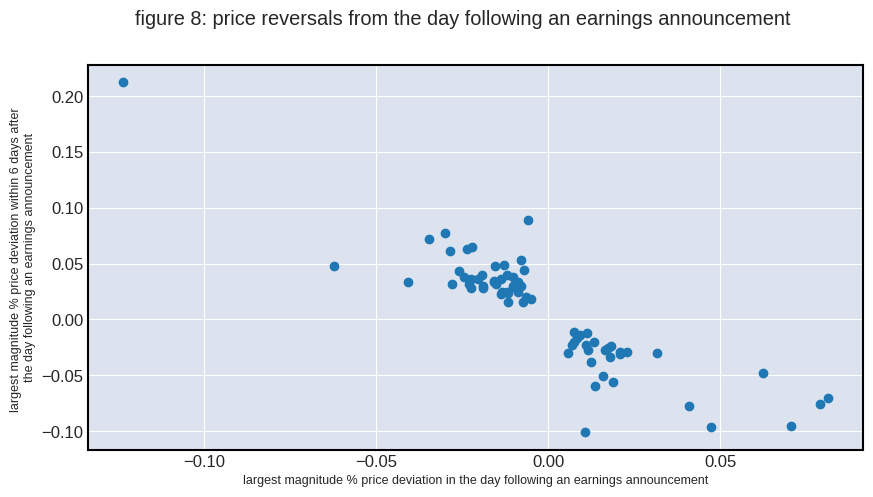

In [31]:
price_reversals = change_comparison.loc[np.sign(change_comparison['6day_pct_price_deviation']) != np.sign(change_comparison['1day_pct_price_deviation'])]

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(price_reversals['1day_pct_price_deviation'], price_reversals['6day_pct_price_deviation'])
ax.set_xlabel('largest magnitude % price deviation in the day following an earnings announcement', font={'size' : 9, 'weight' : 'normal'})
ax.set_ylabel('largest magnitude % price deviation within 6 days after \nthe day following an earnings announcement', font={'size' : 9, 'weight' : 'normal'})

title = fig.suptitle('figure 8: price reversals from the day following an earnings announcement', y=.99, font={'size' : 18, 'weight' : 'bold'})

Findings
-------

The first noteworthy takeaway comes from observing the periods we're trading in the context of the year. In figure 2, we have our trading periods highlighted in red and can see significant jumps in those periods relative to the rest of the year. While this is just one year for one symbol, we would expect this to be the case for many of our periods. Earnings reports are one of the primary drivers of price movement in stock trading. 

From figure 3, we see that a majority of trading during earnings announcements for these symbols occurs on the day of or the day following the announcement. Intuitively, this should make sense. The discussion and trading around earnings reports reaches a crescendo on the day a company is set to release earnings and traders spend the next day digesting the announcment and reflecting their sentiment in the stock's price.

Figure 4 shows the volatility (measured as the mean standard deviation of average price for the one-minute candles) and generally confirms the same ideas conveyed by figure 2: for the most part, each symbol's maximum amount of uncertainty occurs right before the earnings report is released. One deviation from this trend is for AMZN, which shows the most volatile trading day as the day after the earnings report is released. More analysis would need to be done to confirm this isn't due to an outlier, but if it's the case, we should want our model to be able to pick this up.

Table 1 details price direction on open following an earnings release. The important part is that the open after an earnings announcement doesn't always move in the same direction as the difference between actual EPS and mean analyst estimates. This doesn't really tell us much else without any other information.

Figure 5 compares the magnitude change in the stock price to the magnitude difference in actual EPS and mean analyst estimates. Importantly, we see a clear difference in the graphs between the change at open immediately following an earnings release and the largest magnitude difference seen throughout the 7 days thereafter. This suggests that there is potential in not only predicting the earnings reports and their associated impact on the stock price, but also in the specific trading patterns following the release. Otherwise, the largest deviation in price would occur at open and the price would remain relatively stable for the remainder of our period. A key goal of the model is to interpret and adapt to these patterns.

Figure 6 shows that, at least for these periods and symbols, a stock having a greater number of analyst estimates is somewhat correlated with larger differences between actual and mean estimate. [PAPER] suggests that a greater number of estimates should reflect more certainty regarding the stock, but this claim is made in terms of trading patterns following an earnings report and not the actual difference between actual and estimates, as is shown here.

Figure 7 shows a slight correlation in the data between the standard deviation of the analyst estimates and larger differences between actual and estimates. Altogether, the standard deviation are pretty similar, so it's difficult to draw a lot of conclusions for the low sample size; however, this still suggests that the nuances of the analyst estimates can play some impact on the result.

Lastly, Figure 8 depicts price reversals after the day following an earnings report. The figure does not make much comment on them other than to show that they exist for 70 earnings dates out of the total 282. This is a signficant number and we would hope our model would be able to capture when this might happen based on the trading data.